# Convolutional Neural Network Model: for Protein family Identification
### Group-17 - Fawad Ullah, Yogi Koteru, Shirisha Gajjela

## import required Libraries

In [179]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Set random seeds for reproducibility

In [180]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)


## Define functions:
1. to tranform data into dataframe from fasta format
2. distribution plot - to check the distribution of protein length 

In [181]:
def read_fasta(file_path, columns, label):
    records = []
    with open(file_path) as fasta_file:
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_split = title.split(None)
            record.append(title_split[0])
            sequence = " ".join(sequence)
            record.append(sequence)
            record.append(len(sequence))
            records.append(record)
            
    # Append the label 
    for _ in range(len(records)):
        records[_].append(label)

    return pd.DataFrame(records, columns=columns)

def distribution_plot(df):
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)

    ax = sns.displot(data=df, x='sequence_length')
    ax.set(xlim=(df['sequence_length'].min(), df['sequence_length'].max()))
    plt.title(f'Sequence Length Distribution')
    plt.grid(True)


## Dataset

In [182]:
merged_data = pd.DataFrame()  # empty dataframe to concatenate all the dataframe along the loop

# input directory
dir = 'ML_final_project/dataset'

# loop to convert all the input files into a single 
for index, file in enumerate(os.listdir(dir)):
    if file.endswith('.fasta'):
        file_path = os.path.join(dir, file)
        df = read_fasta(file_path, columns=['id', 'sequence', 'sequence_length', 'label'], label=index)
        merged_data = pd.concat([merged_data, df])

# Reset the index to ensure it's unique and continuous
dataset = merged_data.sample(frac=1).reset_index(drop=True)

# get an array of unique labels to use in the output layer of the model
unique_labels = dataset.label.unique()

# print first 5 rows of data
dataset.head()

,id,sequence,sequence_length,label
0,WP_004704431.1,M P Q K T F V L C L L I V C I T V L A F T L I ...,99,4
1,WP_001630031.1,M R Y P V T L T P A P E G G Y M V S F V D I P ...,275,0
2,WP_003662923.1,M H Y P V T L T P D T D G F C V T F R D I P E ...,273,0
3,WP_000775239.1,M K L P G N A L I W C V L I V C C T L L I F T ...,103,4
4,WP_016572009.1,M D L T P Y V D S L H R E L A V A A E A G G D ...,339,2


## Protein length distribution plot

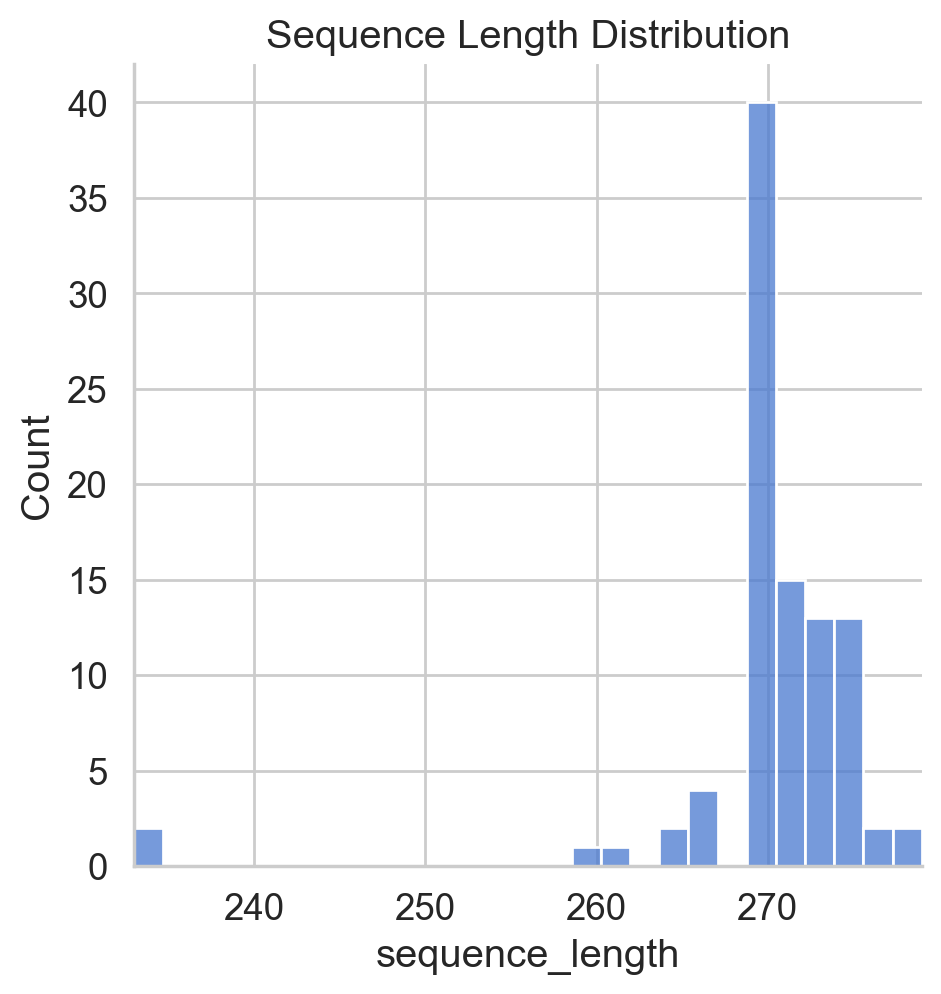

In [183]:
# Visualize the dataframe sequence length to see the distribution of the length of proteins
distribution_plot(df)

## Drop outliers 

In [184]:
mask = (dataset['sequence_length'] <= 105)
dataset = dataset[~mask]

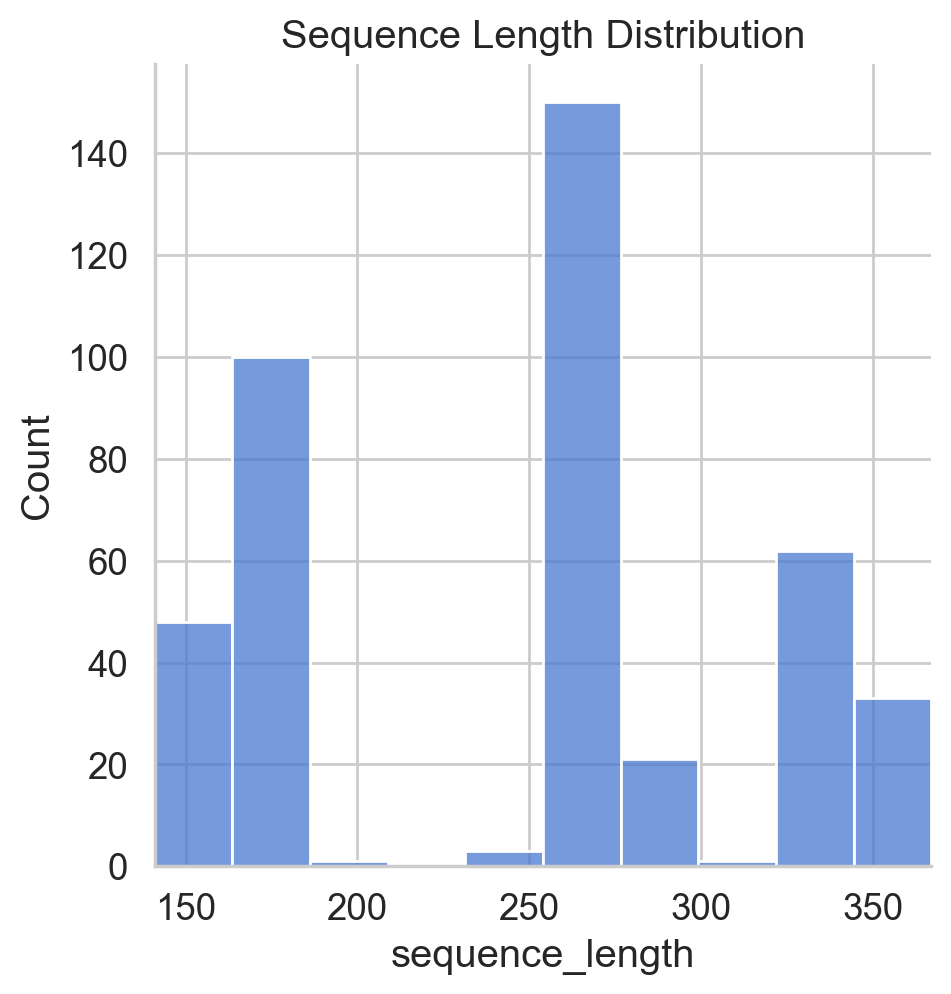

In [185]:
# vasualize the new dataset after dropping the outliers
distribution_plot(df=dataset)

## Feature Engineering and Encoding

In [186]:
# get the sequence column from the dataset
sequences = dataset['sequence']
vocab_size = 20  # Since 20 unique letters in protein
embedding_dim = 32

# Create a tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)

# Fit the tokenizer on the sequences
tokenizer.fit_on_texts(sequences)

# Tokenize the sequences
encoded_sequences = tokenizer.texts_to_sequences(sequences)

# Padding sequences to a maximum length
max_length = 350

# Padding and truncating sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert padded sequences to TensorFlow tensors
padded_sequences_tensor = tf.constant(padded_sequences)


X = padded_sequences_tensor.numpy()

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(dataset.label)

# Convert integer labels to one-hot encoding
y = to_categorical(dataset.label - 1, num_classes=10)
# y_test_one_hot = to_categorical(y_test - 1, num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# print the shapes of the train and test data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (335, 350)
y_train shape: (335, 10)
X_test shape (84, 350)
y_test shape: (84, 10)


### Print first Sample from the X and y

In [187]:
print('First X_train sample:', X_train[0],
      '\nFirst y_train sample label:', y_train[0])

First X_train sample: [15  1  8  1  2  1 12  1 11  1 18  1  6  1  7  1 16  1  2  1 10  1  4  1
  5  1 19  1  3  1 12  1  2  1  3  1  5  1  3  1 10  1 10  1  8  1  5  1
  7  1  4  1  3  1  2  1  6  1  5  1  4  1  2  1 12  1 10  1  7  1  2  1
  5  1  7  1  3  1  9  1  4  1 15  1 12  1  2  1  2  1  8  1  3  1  2  1
  7  1  3  1  3  1 12  1  8  1  5  1  9  1 12  1 13  1  8  1  2  1  3  1
 11  1 10  1  7  1  6  1  5  1  2  1  4  1  2  1  4  1 10  1  4  1  8  1
 11  1 16  1 19  1  6  1  6  1 12  1  3  1  4  1 11  1  3  1  5  1 11  1
  9  1  5  1  5  1  3  1  3  1  5  1 16  1  8  1  3  1  3  1 11  1  3  1
  8  1 10  1 10  1 12  1 11  1  9  1  3  1  5  1  8  1 10  1 11  1 12  1
  3  1  4  1  9  1 16  1  6  1  4  1  2  1 11  1  5  1 13  1  2  1 14  1
  3  1  3  1  6  1  5  1  5  1  3  1  3  1  3  1 14  1  5  1 10  1  4  1
  7  1  6  1 16  1  3  1 17  1  2  1  6  1  4  1  3  1  3  1  7  1  7  1
  3  1  2  1 13  1 13  1 11  1  8  1  4  1  6  1 13  1 20  1  3  1 13  1
 13  1  4  1 10  1 14  1 13  

## Model architecture

In [188]:
# Define your model architecture
model = Sequential()

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Add a dropout layer to 
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# output layer
model.add(Dense(len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

gradient = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Print the model summary
model.summary()


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1716 - loss: 3.1073 - val_accuracy: 0.3582 - val_loss: 1.8705
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4293 - loss: 1.6522 - val_accuracy: 0.4776 - val_loss: 1.5643
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5430 - loss: 1.3311 - val_accuracy: 0.5672 - val_loss: 1.3199
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6339 - loss: 1.0769 - val_accuracy: 0.7463 - val_loss: 1.0100
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7284 - loss: 0.8430 - val_accuracy: 0.8060 - val_loss: 0.7954
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8424 - loss: 0.7134 
Test Loss: 0.7659839987754822
Test Accuracy: 0.8333333134651184


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │        22,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,960 (316.25 KB)

 Trainable params: 26,986 (105.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,974 (210.84 KB)

## Plot the train and test accuracies and loss

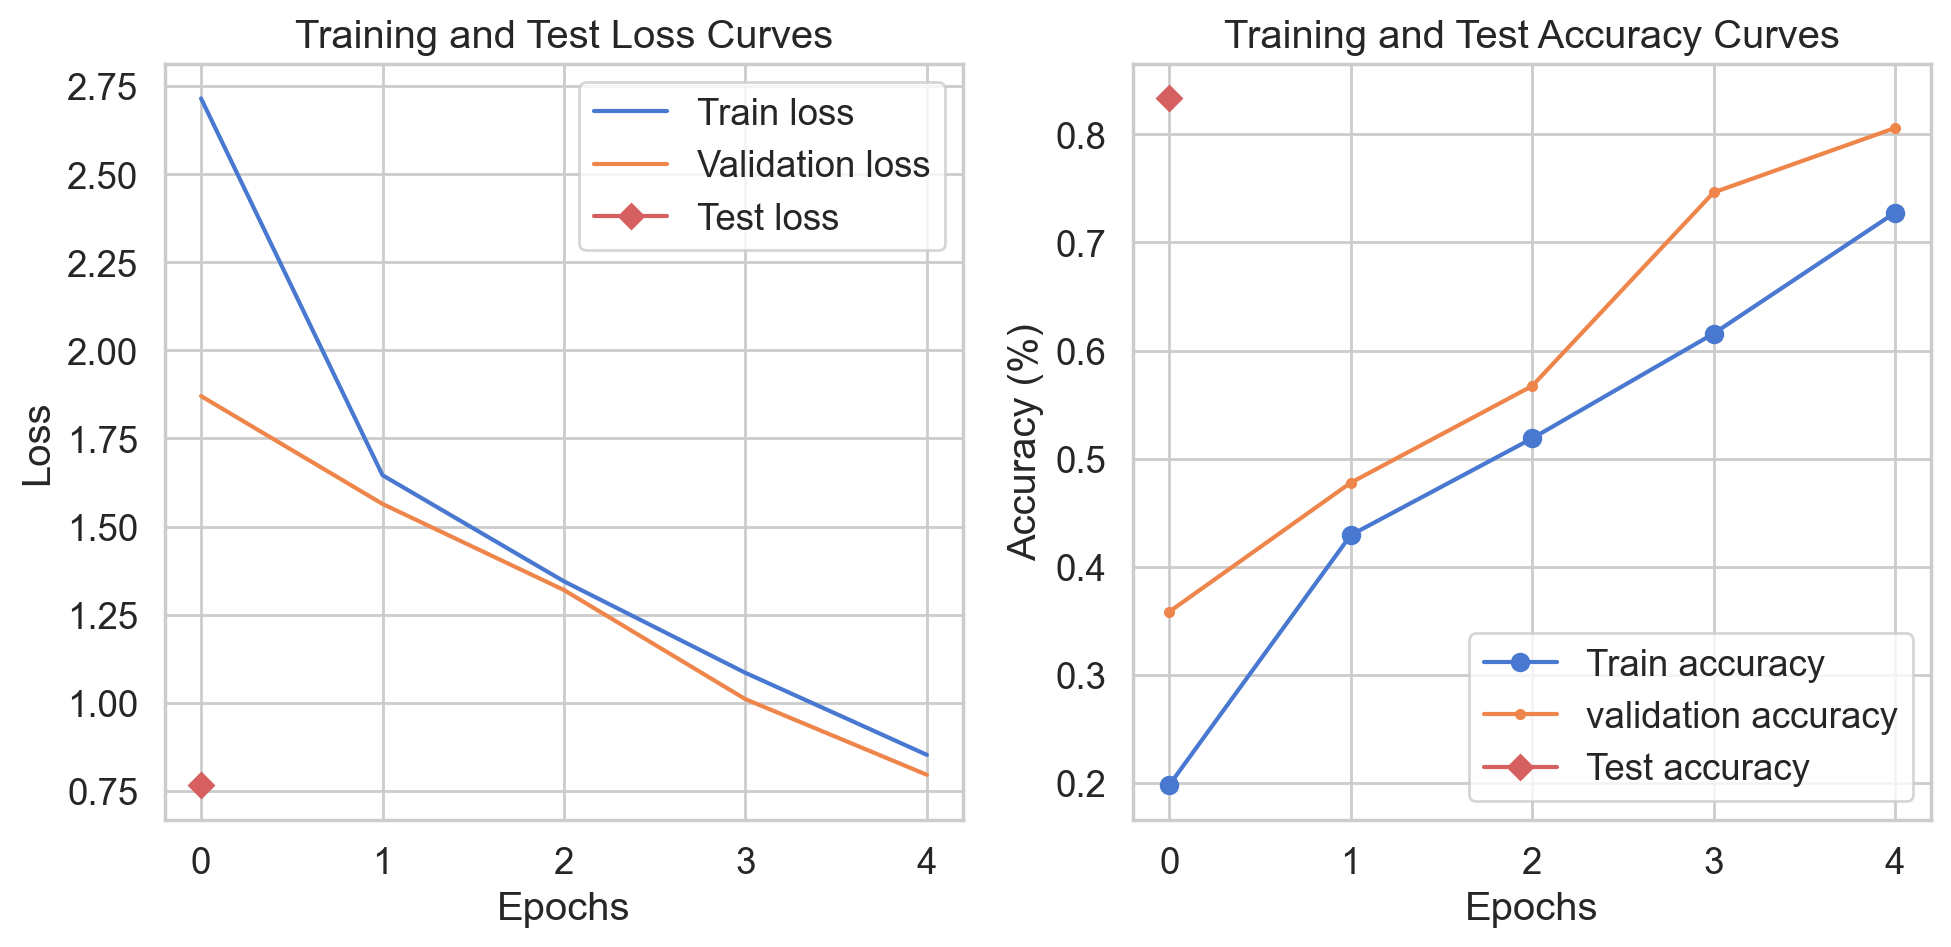

In [189]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gradient.history['loss'], label="Train loss")
plt.plot(gradient.history['val_loss'], label="Validation loss")
plt.plot(test_loss, marker='D', color='r', label='Test loss')
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gradient.history['accuracy'], label="Train accuracy", marker='o')
plt.plot(gradient.history['val_accuracy'], label="validation accuracy", marker='.')
plt.plot(test_accuracy, marker='D', color='r', label='Test accuracy')
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()



# Predict the test data

In [190]:
# predictions for the test dataset X_test
y_pred = model.predict(X_test)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Assuming y_test contains the true labels for the test dataset
# You might need to convert it to labels if it's in one-hot encoded form
y_true_labels = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


## Calculate Precision_score, recall_score and f1_score

In [191]:
# Calculate precision
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')

# Calculate recall
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8222298534798534
Recall: 0.8333333333333334
F1-score: 0.8017630919804833


c:\Users\Amjad Naseem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
